## Import required libraries

#### Install required librqries and packeges

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=87729c8a4670c6e13526506452872ee3d3c58f934b4287a9cd84e02f188aea09
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
ERROR: Operation cancelled by user


#### Import required librqries and packeges

In [ ]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import graphviz
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# Initialize the Random Forest model
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import iqr  # To calculate interquartile range
from lime import lime_tabular
from tqdm import tqdm  # For progress tracking
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


ModuleNotFoundError: No module named 'lime'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Importing and extracting datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/UJ/Colabs/1st_semester/xai_for_ts_1st_task/data'

#### Train Dataset

In [ ]:
# Function to parse MATLAB-like matrices
def parse_matlab_matrix(line):
    line = line.strip()[1:-1]
    rows = line.strip().split(';')
    data = []
    for row in rows:
        elements = row.strip().split()
        data.append([float(el) for el in elements])
    return np.array(data)

In [ ]:
# Load training data
train_file = os.path.join(data_path, 'PEMS_train')
X_train = []
with open(train_file, 'r') as f:
    for idx, line in enumerate(f):
        line = line.strip()
        if not line:
            continue
        if not line.startswith('[') or not line.endswith(']'):
            print(f'Line {idx+1} is not a valid matrix.')
            continue
        try:
            matrix = parse_matlab_matrix(line)
            X_train.append(matrix)
            if (idx + 1) % 50 == 0:
                print(f'Loaded {len(X_train)} samples')
        except Exception as e:
            print(f'Error parsing line {idx+1}: {e}')

X_train = np.array(X_train)
print('Training data shape:', X_train.shape)

In [ ]:
train_labels_file = os.path.join(data_path, 'PEMS_trainlabels')

# Read the entire content
with open(train_labels_file, 'r') as f:
    content = f.read()

# Remove square brackets and newlines
content = content.strip().replace('[', '').replace(']', '')

# Split into individual labels
label_strings = content.split()

# Convert to integers
y_train = np.array([int(label) for label in label_strings])
print('Training labels shape:', y_train.shape)


#### Test Dataset

In [ ]:
# Load test data
test_file = os.path.join(data_path, 'PEMS_test')
X_test = []
with open(test_file, 'r') as f:
    for idx, line in enumerate(f):
        line = line.strip()
        if not line:
            continue
        if not line.startswith('[') or not line.endswith(']'):
            print(f'Line {idx+1} is not a valid matrix.')
            continue
        try:
            matrix = parse_matlab_matrix(line)
            X_test.append(matrix)
        except Exception as e:
            print(f'Error parsing line {idx+1}: {e}')

X_test = np.array(X_test)
print('Test data shape:', X_test.shape)

# Load test labels
test_labels_file = os.path.join(data_path, 'PEMS_testlabels')
with open(test_labels_file, 'r') as f:
    content = f.read()

content = content.strip().replace('[', '').replace(']', '')
label_strings = content.split()
y_test = np.array([int(label) for label in label_strings])
print('Test labels shape:', y_test.shape)

## Summarizing the Dataset

#### Dataset Shape and Class Distribution

In [ ]:
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)

We are working with a  train dataset that contains 267 samples, each representing a day of the week. The data includes 963 sensor features, capturing the occupancy rate (between 0 and 1), through the day. For each day, the sensor readings are recorded across 144 time intervals, with each interval representing a 10-minute span, covering the full 24 hours of the day. The samples are categorized into seven classes, corresponding to the days of the week, with labels ranging from 1 for Monday to 7 for Sunday.

In [ ]:
unique_labels, counts = np.unique(y_train, return_counts=True)
label_distribution = dict(zip(unique_labels, counts))
print('Training label distribution:', label_distribution)

Sunday (7) has the highest count with 44 samples. This distribution provides a slightly imbalanced dataset, with more samples for the weekend compared to the earlier days of the week. This distribution provides a slightly imbalanced dataset, with more samples for the weekend compared to the earlier days of the week.

#### Key Statistics

##### Overall Mean and Variance

In [ ]:
overall_mean = np.mean(X_train)
overall_variance = np.var(X_train)

print('Overall Mean Occupancy Rate:', overall_mean)
print('Overall Variance in Occupancy Rate:', overall_variance)

On average, the overall occupancy rate is about 0.0531, which means the car lanes are not heavily occupied most of the time. The overall variance in the data is 0.00226, showing only slight fluctuations in the occupancy rates across all the records.

In [ ]:
means_per_sample = np.mean(X_train, axis=(1,2))  # Mean over sensors and time intervals
variances_per_sample = np.var(X_train, axis=(1,2))

print('Mean of means per sample:', np.mean(means_per_sample))
print('Mean of variances per sample:', np.mean(variances_per_sample))

When we look at each day's data, the average occupancy rate remains consistent at 0.0531, and the average variance within each day is slightly lower, around 0.00221. This suggests that the daily patterns of occupancy are stable, with small variations in the sensor readings throughout the day.

### Visualizing the Data

In [ ]:
sensor_index = 100  # Random sensor selected between 0 and 962

plt.figure(figsize=(12, 6))

# Plot occupancy for the first sample of each class (day of the week)
for day in range(1, 8):
    # Find the first occurrence of each day
    day_indices = np.where(y_train == day)[0]
    if len(day_indices) > 0:
        idx = day_indices[0]
        plt.plot(X_train[idx, sensor_index, :], label=f'Day {day} (Sample {idx})')

plt.title(f'Occupancy Rate Over Time for Sensor {sensor_index} from Mondey to Sunday (sample 0)')
plt.xlabel('Time Interval (every 10 minutes)')
plt.ylabel('Occupancy Rate')
plt.legend()
plt.show()

From the plot, we can observe that the occupancy rate for most days exhibits a peak around time intervals 40 to 60, suggesting a period of increased usage, potentially corresponding to rush hours. After this peak, the occupancy rate declines steadily

The brown line represents Day 6, which corresponds to Saturday. This day shows a notably higher occupancy rate, with a significant peak around time intervals 40 to 60, likely indicating a surge in traffic during that time. After the peak, the occupancy rate gradually decreases, but it remains higher than other days throughout much of the day. This could suggest that Saturdays experience more consistent traffic, possibly due to weekend activities, compared to the other days shown on the chart.

#### Plot Histogram of Occupancy Rates for a Specific Day:

In [ ]:
day_index = 0  # Index of the day in X_train

# Flatten the occupancy data for that day
occupancy_data = X_train[day_index].flatten()

plt.figure(figsize=(8, 6))
plt.hist(occupancy_data, bins=50, edgecolor='k')
plt.title(f'Occupancy Rate Distribution for Day {y_train[day_index]} (Sample {day_index})')
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.show()

this histogram shows that on Day 3, the lanes were mostly underused, with very few moments of high occupancy. The traffic flow was likely smooth for much of the day.
The high frequency comes from combining occupancy data across all 963 sensors.

#### Create a Heatmap of Occupancy Rates for All Sensors Over Time for a Specific Day:

In [ ]:
day_index = 0  # Index of the day in X_train

# Extract data for the selected day
X_day = X_train[day_index]  # Shape: (963, 144)

time_points = [48, 102]  # Corresponding to 8 AM and 5 PM

# Compute mean occupancy per sensor across all time intervals
mean_occupancy_per_sensor = X_day.mean(axis=1)  # Shape: (963,)

# Get indices that would sort the sensors by mean occupancy rate in descending order
sorted_indices = np.argsort(mean_occupancy_per_sensor)[::-1]  # Descending order

# Reorder the sensors in X_day based on sorted_indices
X_day_sorted = X_day[sorted_indices, :]  # Shape: (963, 144)

# Plot the heatmap with reordered sensors
plt.figure(figsize=(14, 10))
sns.heatmap(X_day_sorted, cmap='viridis', cbar_kws={'label': 'Occupancy Rate'})
plt.title(f'Occupancy Heatmap for Day {y_train[day_index]} (Sample {day_index}) - Sensors Ordered by Mean Occupancy Rate')
plt.xlabel('Time Interval (every 10 minutes)')
plt.ylabel('Sensor Index (ordered by mean occupancy rate)')
# Add vertical lines
for tp in time_points:
    plt.axvline(x=tp, color='red', linestyle='--')
plt.show()

The two vertical lines on the heatmap represent the busiest times of the day, likely when people are going to work in the morning and returning home in the evening. The first peak happens between intervals 30 and 60, likely the morning rush hour (around 7-9 AM). The second peak occurs between intervals 90 and 120, which probably represents the evening rush hour (around 4-6 PM).

In between these peaks, there are smaller areas of high occupancy, which might be places with restaurants or other spots where people gather during lunch or other parts of the day. This heatmap shows us the typical traffic patterns, with the busiest times during the workday commutes.


#### Calculate Mean Occupancy Rates per Sensor for Each Day of the Week

In [ ]:
# Initialize a list to store mean occupancy per sensor for each day of the week
mean_occupancy_per_sensor_per_day = []

# Days of the week labels
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Loop over days of the week (1 to 7)
for day_label in range(1, 8):
    # Find indices where the day label matches
    day_indices = np.where(y_train == day_label)[0]

    # Extract data for these days
    X_day = X_train[day_indices]  # Shape: (num_days_for_this_day, 963, 144)

    # Check if there are days for this day_label
    if X_day.size == 0:
        print(f"No data for {days_of_week[day_label - 1]}")
        mean_occupancy_per_sensor = np.array([])
    else:
        # Compute mean occupancy per sensor, averaging over days and timestamps
        # Mean over axis=0 (days) and axis=2 (timestamps)
        mean_occupancy_per_sensor = X_day.mean(axis=(0, 2))  # Shape: (963,)

    # Append to the list
    mean_occupancy_per_sensor_per_day.append(mean_occupancy_per_sensor)


In [ ]:
sensor_id = 100  # Sensor index (0 to 962)

# Initialize a list to store mean occupancy per day for the sensor
mean_occupancy_per_day_per_sensor = []

# Loop over days of the week
for day_label in range(1, 8):
    day_indices = np.where(y_train == day_label)[0]
    X_day = X_train[day_indices]  # Shape: (num_days, 963, 144)
    if X_day.size == 0:
        mean_occupancy = np.nan
    else:
        # Mean over days and timestamps for the specific sensor
        mean_occupancy = X_day[:, sensor_id, :].mean()
    mean_occupancy_per_day_per_sensor.append(mean_occupancy)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(days_of_week, mean_occupancy_per_day_per_sensor)
plt.title(f'Mean Occupancy Rate for Sensor {sensor_id} by Day of the Week')
plt.ylabel('Mean Occupancy Rate')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()


#### Create Boxplots for Each Day of the Week


In [ ]:
# Set up the plot
plt.figure(figsize=(15, 10))

# Loop over each day to create subplots
for i, mean_occupancy in enumerate(mean_occupancy_per_sensor_per_day):
    plt.subplot(3, 3, i+1)
    if mean_occupancy.size > 0:
        plt.boxplot(mean_occupancy, vert=True)
        plt.title(days_of_week[i])
        plt.ylabel('Mean Occupancy Rate')
        plt.xlabel('Sensors')
        plt.xticks([])  # Hide x-axis ticks since there are many sensors
    else:
        plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center')
        plt.title(days_of_week[i])
        plt.axis('off')

plt.tight_layout()
plt.show()


#### Identify Outlier Sensors for Each Day

In [ ]:
# Initialize a list to store outlier sensor indices for each day
outlier_sensors_per_day = []

for i, mean_occupancy in enumerate(mean_occupancy_per_sensor_per_day):
    day_name = days_of_week[i]
    print(f"\nProcessing {day_name}")

    if mean_occupancy.size == 0:
        print("No data available")
        outlier_sensors = []
    else:
        # Calculate Q1, Q3, and IQR
        Q1 = np.percentile(mean_occupancy, 25)
        Q3 = np.percentile(mean_occupancy, 75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outlier sensors
        outlier_indices = np.where((mean_occupancy < lower_bound) | (mean_occupancy > upper_bound))[0]
        outlier_sensors = outlier_indices.tolist()

        print(f"Number of outlier sensors on {day_name}: {len(outlier_sensors)}")
        print(f"Outlier sensor indices: {outlier_sensors}")

    # Append to the list
    outlier_sensors_per_day.append(outlier_sensors)


#### Visualizing Outlier Sensors


In [ ]:
# Count of outlier sensors per day
outlier_counts = [len(outliers) for outliers in outlier_sensors_per_day]

plt.figure(figsize=(8, 5))
plt.bar(days_of_week, outlier_counts, color='skyblue')
plt.title('Number of Outlier Sensors per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Outlier Sensors')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



## Feature Engineering

##### Prepare train data

In [ ]:
# Assuming X_train has shape (num_days, num_sensors, num_intervals)
num_days, num_sensors, num_intervals = X_train.shape

# Calculate the mean occupancy for each sensor over all days and intervals
sensor_mean_occupancy = X_train.mean(axis=(0, 2))  # Shape: (num_sensors,)

# Create a DataFrame to store sensor IDs and their mean occupancy
sensor_occupancy_df = pd.DataFrame({
    'sensor_id': np.arange(num_sensors),
    'mean_occupancy': sensor_mean_occupancy
})

print(sensor_occupancy_df.head())


In [ ]:
# Calculate quantiles for grouping
low_threshold = sensor_occupancy_df['mean_occupancy'].quantile(1/3)
high_threshold = sensor_occupancy_df['mean_occupancy'].quantile(2/3)

# Function to assign group based on occupancy
def assign_group(occupancy):
    if occupancy <= low_threshold:
        return 'Low'
    elif occupancy <= high_threshold:
        return 'Medium'
    else:
        return 'High'

# Assign groups to sensors
sensor_occupancy_df['group'] = sensor_occupancy_df['mean_occupancy'].apply(assign_group)

print(sensor_occupancy_df.head())
print(sensor_occupancy_df['group'].value_counts())


In [ ]:
# Each interval is 10 minutes; 144 intervals per day
# Define time periods (you can adjust these ranges)
time_periods = {
    'morning': range(0, 48),   # 00:00 to 08:00
    'day': range(48, 96),      # 08:00 to 16:00
    'night': range(96, 144)    # 16:00 to 24:00
}

def extract_group_time_features(samples, sensor_groups):
    num_days, num_sensors, num_intervals = samples.shape
    data_list = []

    for day_idx in range(num_days):
        for sensor_idx in range(num_sensors):
            # Get the group of the sensor
            sensor_group = sensor_groups.loc[sensor_idx, 'group']

            for period_name, intervals in time_periods.items():
                # Extract data for the current sensor on the current day and time period
                sensor_data = samples[day_idx, sensor_idx, intervals]

                # Compute features
                features = {
                    'day': day_idx,
                    'sensor_id': sensor_idx,
                    'sensor_group': sensor_group,
                    'time_period': period_name,
                    'mean': np.mean(sensor_data),
                    'median': np.median(sensor_data),
                    'min': np.min(sensor_data),
                    'max': np.max(sensor_data),
                    'iqr': iqr(sensor_data),
                    'peak_time': np.argmax(sensor_data) + intervals.start  # Adjust peak_time
                }

                data_list.append(features)

    # Return the DataFrame containing all features
    return pd.DataFrame(data_list)


In [ ]:
# Ensure sensor_occupancy_df is indexed by sensor_id
sensor_groups = sensor_occupancy_df.set_index('sensor_id')

# Extract features
sensor_day_features = extract_group_time_features(X_train, sensor_groups)

print('Feature DataFrame shape:', sensor_day_features.shape)
print('First few rows:\n', sensor_day_features.head())


In [ ]:
# Aggregate features by day, sensor group, and time period
aggregated_features = sensor_day_features.groupby(['day', 'sensor_group', 'time_period']).agg({
    'mean': 'mean',
    'median': 'mean',
    'min': 'mean',
    'max': 'mean',
    'iqr': 'mean',
    'peak_time': 'mean'
}).reset_index()

print(aggregated_features.head())


In [ ]:
# Pivot the table to wide format
pivot_df = aggregated_features.pivot_table(
    index='day',
    columns=['sensor_group', 'time_period'],
    values=['mean', 'median', 'min', 'max', 'iqr', 'peak_time']
)

# Flatten the multi-level columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.reset_index(inplace=True)

print('Pivoted DataFrame shape:', pivot_df.shape)
print(pivot_df.head())


In [ ]:
# Create DataFrame for labels
labels_df = pd.DataFrame({'day': np.arange(len(y_train)), 'label': y_train})

# Merge features with labels
final_df = pivot_df.merge(labels_df, on='day')

# Features and target
X_train = final_df.drop(['day', 'label'], axis=1)
y_train = final_df['label']

print('Final DataFrame shape:', final_df.shape)
print(final_df.head())


##### Prepare test data

In [ ]:
# Extract features from test data using the same sensor groups
sensor_day_features_test = extract_group_time_features(X_test, sensor_groups)

print('Test Feature DataFrame shape:', sensor_day_features_test.shape)
print('First few rows:\n', sensor_day_features_test.head())


In [ ]:
# Aggregate features by day, sensor group, and time period
aggregated_features_test = sensor_day_features_test.groupby(['day', 'sensor_group', 'time_period']).agg({
    'mean': 'mean',
    'median': 'mean',
    'min': 'mean',
    'max': 'mean',
    'iqr': 'mean',
    'peak_time': 'mean'
}).reset_index()

# Pivot the table to wide format
pivot_test = aggregated_features_test.pivot_table(
    index='day',
    columns=['sensor_group', 'time_period'],
    values=['mean', 'median', 'min', 'max', 'iqr', 'peak_time']
)

# Flatten the multi-level columns
pivot_test.columns = ['_'.join(col).strip() for col in pivot_test.columns.values]
pivot_test.reset_index(inplace=True)

print('Pivoted Test DataFrame shape:', pivot_test.shape)
print(pivot_test.head())


In [ ]:
# Create DataFrame for test labels
labels_test_df = pd.DataFrame({'day': np.arange(len(y_test)), 'label': y_test})

# Merge features with labels
final_test_df = pivot_test.merge(labels_test_df, on='day')

# Features and target for test data
X_test_model = final_test_df.drop(['day', 'label'], axis=1)
y_test_model = final_test_df['label']

print('Final Test DataFrame shape:', final_test_df.shape)
print(final_test_df.head())


##### final index adjustment

In [ ]:
y_train = y_train - 1
y_test_model = y_test_model - 1

In [ ]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)


## XGBOOST

In [ ]:


# Initialize and train the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_model)

# Evaluate the model
accuracy = accuracy_score(y_test_model, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(y_test_model, y_pred))

# Confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test_model, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:49:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8844
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.77      0.96      0.86        25
           2       0.91      0.81      0.86        26
           3       0.75      0.65      0.70        23
           4       0.78      0.82      0.80        22
           5       0.96      0.93      0.94        27
           6       1.00      1.00      1.00        20

    accuracy                           0.88       173
   macro avg       0.88      0.88      0.88       173
weighted avg       0.89      0.88      0.88       173

Confusion Matrix:
[[30  0  0  0  0  0  0]
 [ 0 24  1  0  0  0  0]
 [ 0  3 21  2  0  0  0]
 [ 0  2  1 15  5  0  0]
 [ 0  0  0  3 18  1  0]
 [ 0  2  0  0  0 25  0]
 [ 0  0  0  0  0  0 20]]


#### Implementing explainers

##### Shap

shap_values shape: (100, 54, 7)
X_test_sample shape: (100, 54)
Class 0


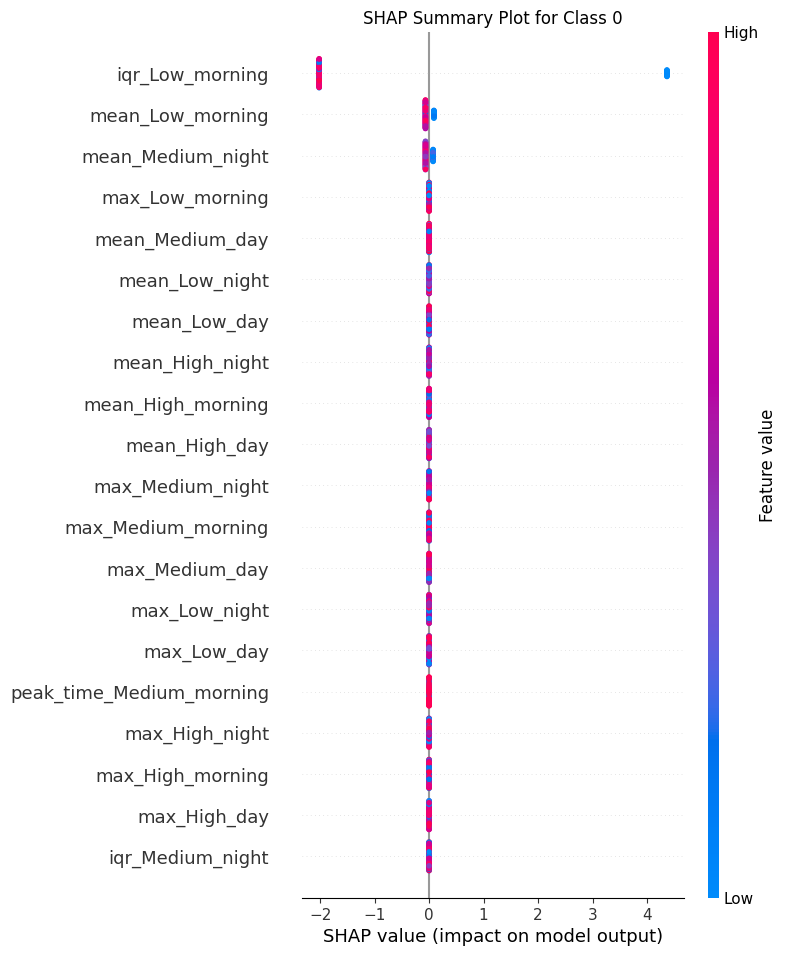

Class 1


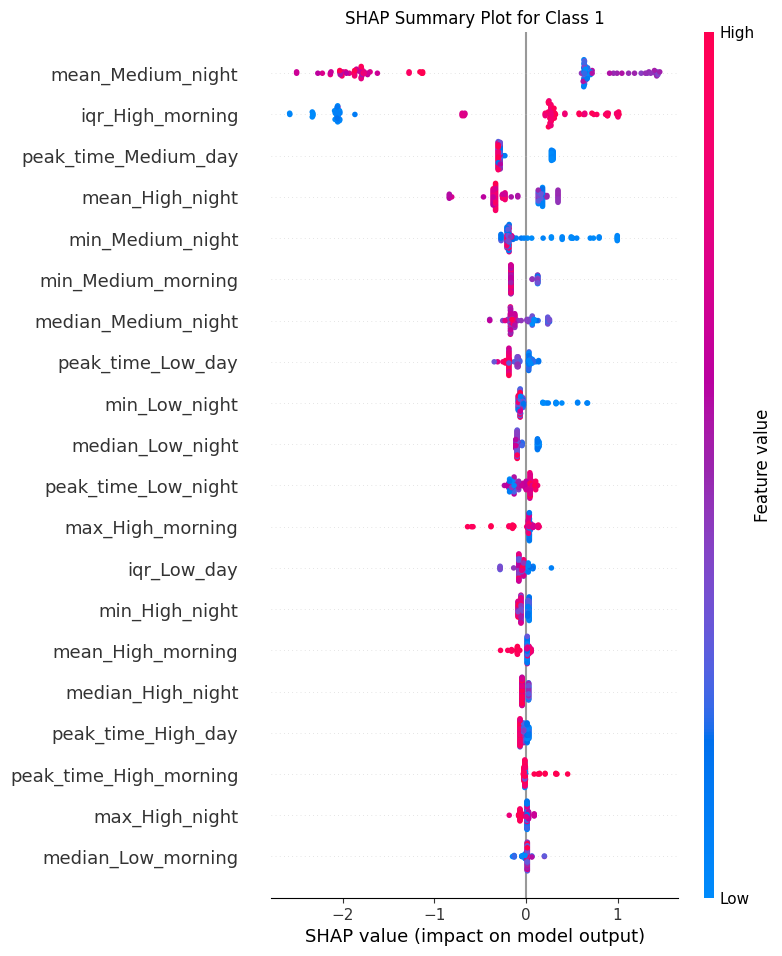

Class 2


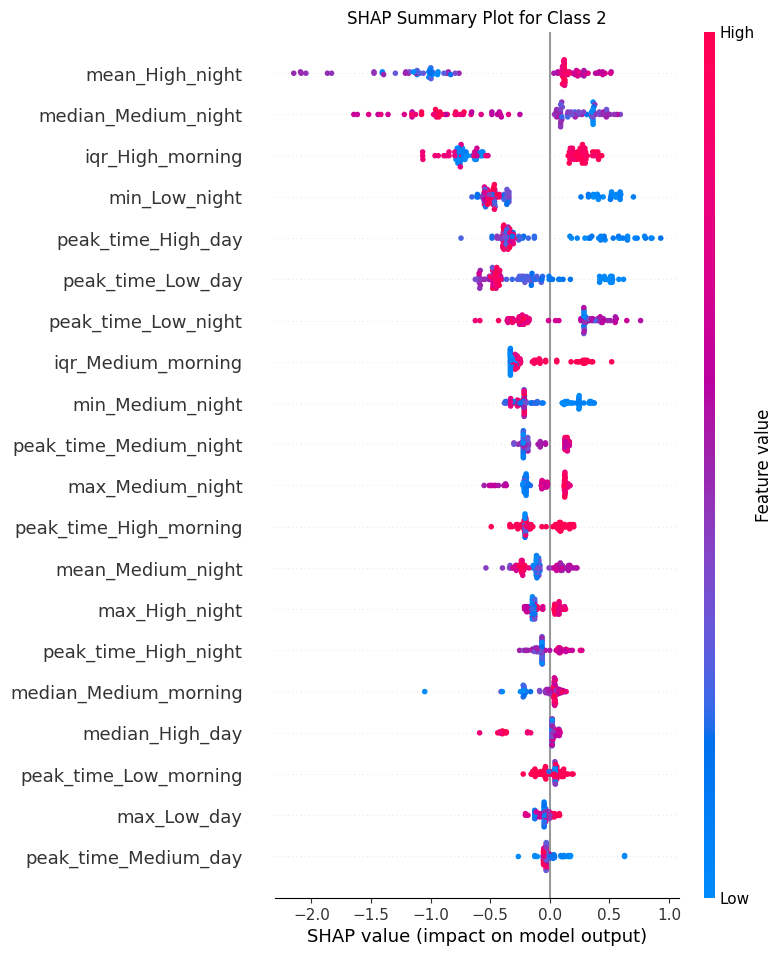

Class 3


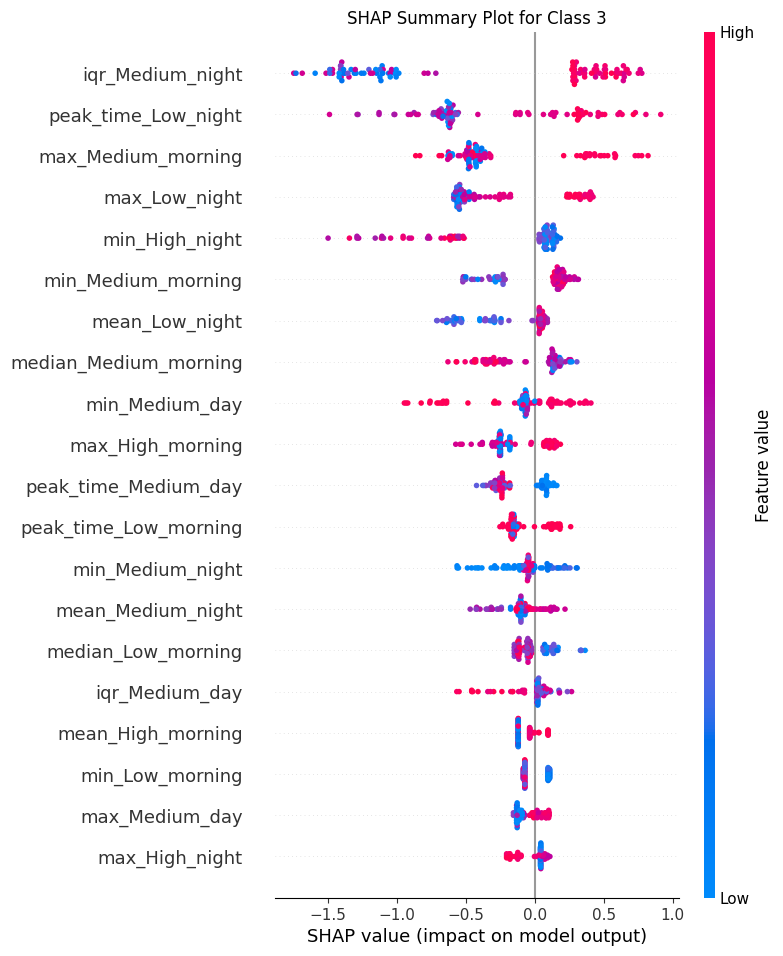

Class 4


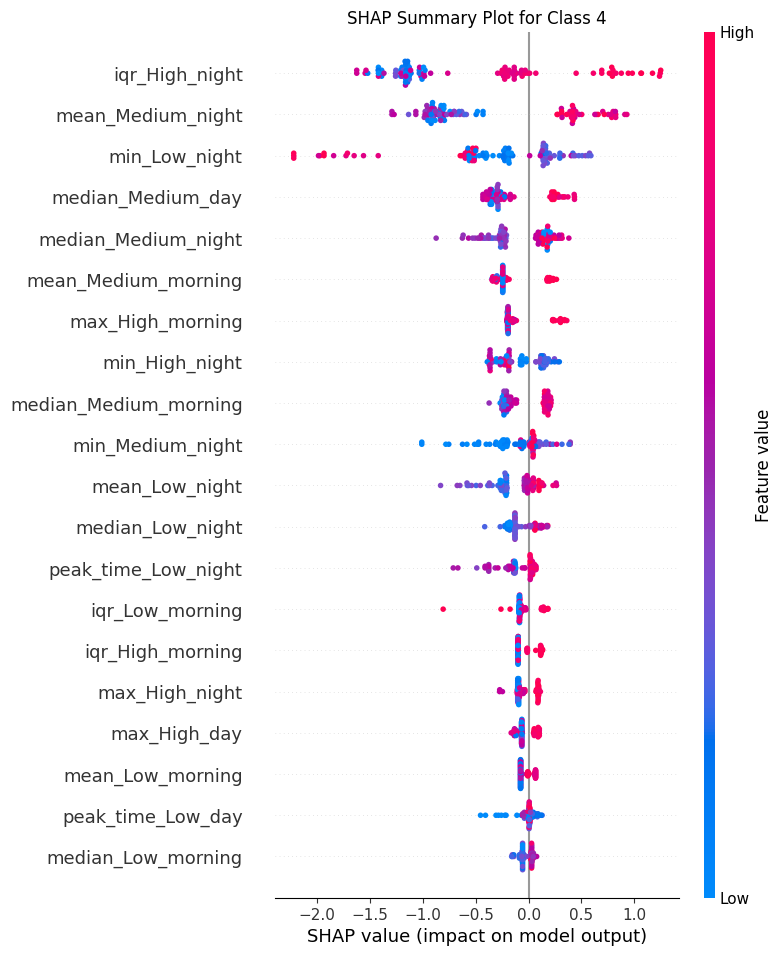

Class 5


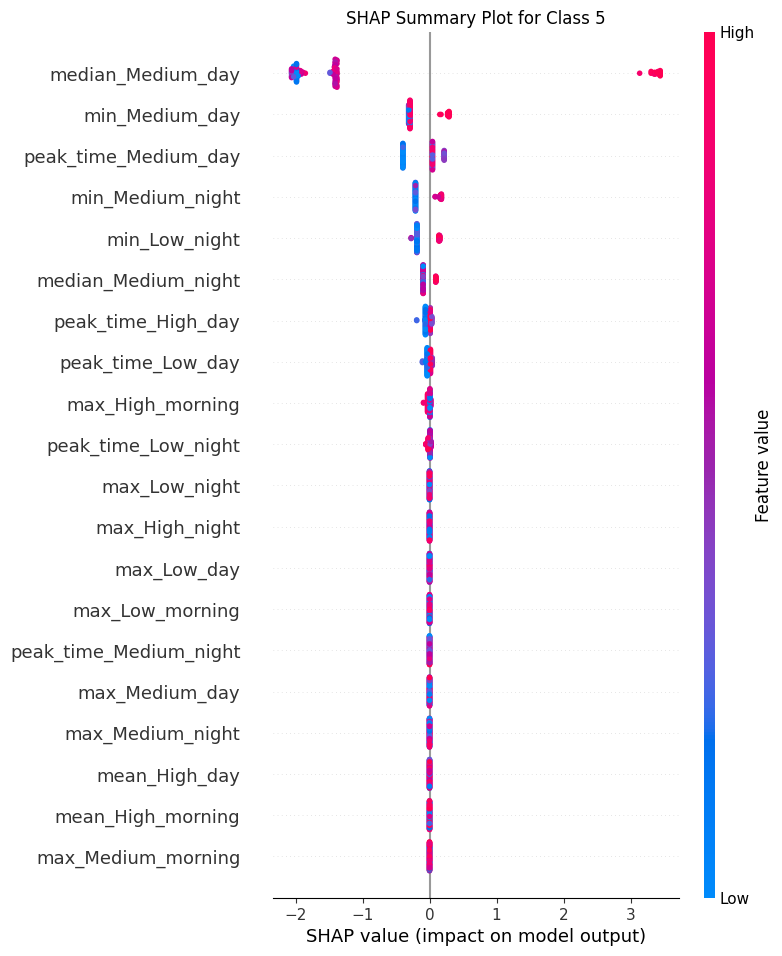

Class 6


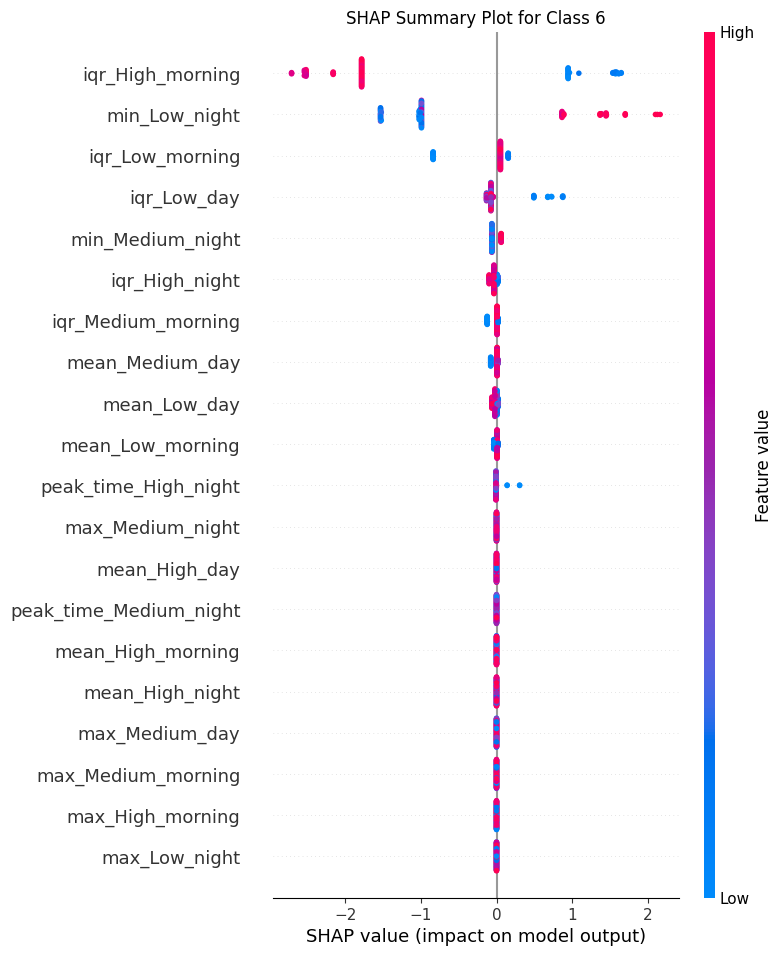

In [ ]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Select a sample of the test data
num_samples = 100
X_test_sample = X_test_model.iloc[:num_samples]

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Check the shape of shap_values
print("shap_values shape:", shap_values.shape)
print("X_test_sample shape:", X_test_sample.shape)

# Plot summary plot for all classes
num_classes = shap_values.shape[2]
for class_index in range(num_classes):
    print(f"Class {class_index}")
    shap.summary_plot(shap_values[:, :, class_index], X_test_sample, show=False)
    plt.title(f'SHAP Summary Plot for Class {class_index}')
    plt.show()

##### Lime

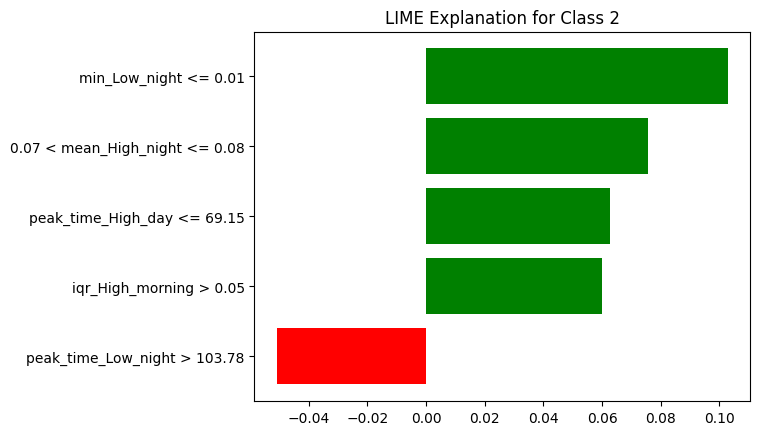

In [ ]:
# Choose an instance to explain
instance_index = 1  # Adjust as needed
instance = X_test_model.iloc[instance_index]

# Get the predicted class for the instance
predicted_class = model.predict(instance.to_frame().T)[0]

# Initialize LIME explainer
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=[str(i) for i in np.unique(y_train)],
    mode='classification'
)

# Define prediction function
def predict_proba_fn(data):
    return model.predict_proba(data)

# Explain the instance using LIME
exp = explainer_lime.explain_instance(
    data_row=instance.values,
    predict_fn=predict_proba_fn,
    num_features=5,
    labels=[predicted_class]
)

# Display the explanation
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure(label=predicted_class)
plt.title(f'LIME Explanation for Class {predicted_class}')
plt.show()


##### Xgboost trees

<Figure size 5000x1000 with 0 Axes>

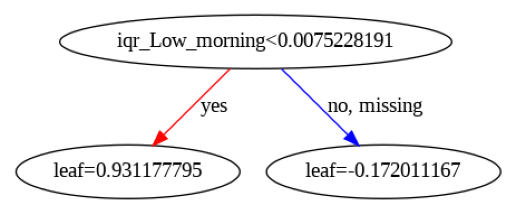

'xgboost_tree.pdf'

In [ ]:
# Step 1: Plot a Single Tree from XGBoost
plt.figure(figsize=(50, 10))
xgb.plot_tree(model, num_trees=0)  # Plot the 0th tree from the model
plt.show()

# Step 2: Export Tree to Graphviz Format for Detailed Visualization
dot_data = xgb.to_graphviz(model, num_trees=0)  # Convert the first tree directly
dot_data.render("xgboost_tree")  # Save as a file
dot_data.view()  # View the tree in the default viewer

## RandomForest

In [ ]:
# Verify shapes of the training and test data
print('X_train shape:', X_train.shape)
print('X_test_model shape:', X_test_model.shape)

# Flatten the data
X_train_flat = X_train.values.reshape(X_train.shape[0], -1)
X_test_flat = X_test_model.values.reshape(X_test_model.shape[0], -1)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train_flat, y_train)

# Print best parameters found
print("Best parameters found: ", random_search.best_params_)

# Retrieve the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Make predictions using the best model
y_pred_best_rf = best_rf_model.predict(X_test_flat)

# Evaluate the best model
accuracy_best_rf = accuracy_score(y_test_model, y_pred_best_rf)
print(f'Best Random Forest Accuracy: {accuracy_best_rf:.4f}')

# Generate and print the classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_test_model, y_pred_best_rf))


X_train shape: (267, 54)
X_test_model shape: (173, 54)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Best Random Forest Accuracy: 0.9191
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.96      0.98        25
           2       0.96      0.88      0.92        26
           3       0.74      0.74      0.74        23
           4       0.77      0.91      0.83        22
           5       0.96      0.93      0.94        27
           6       1.00      1.00      1.00        20

    accuracy                           0.92       173
   macro avg       0.92      0.92      0.92       173
weighted avg       0.92      0.92      0.92       173

Confusion Matrix:
[[30  0  0  0  0  0  0]
 [ 0 24  1  0  0  0  0]
 [ 0  0 23  3  0  0  0]
 [ 0  0  0 17  6  0  0]
 [ 0  0  0  1 20  1  0]
 [ 0  0  0  2  0 25  0]
 [ 0  0  0  0  0  0 20]]


#### SHAP

shap_values shape: (100, 54, 7)
X_test_sample shape: (100, 54)
Class 0


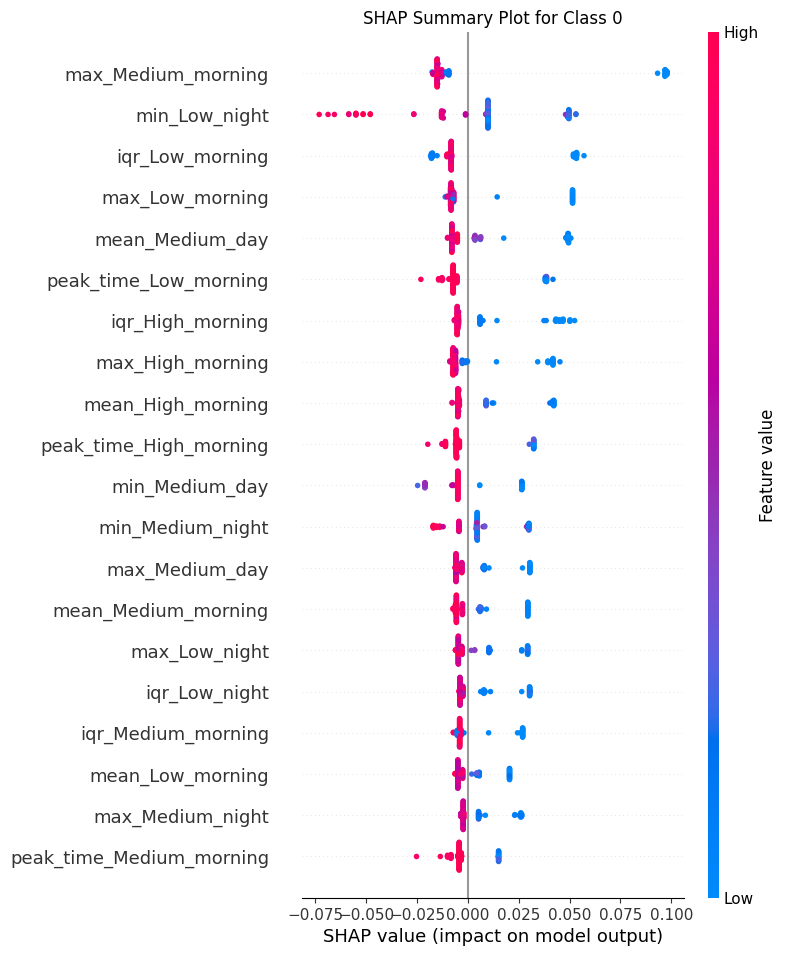

Class 1


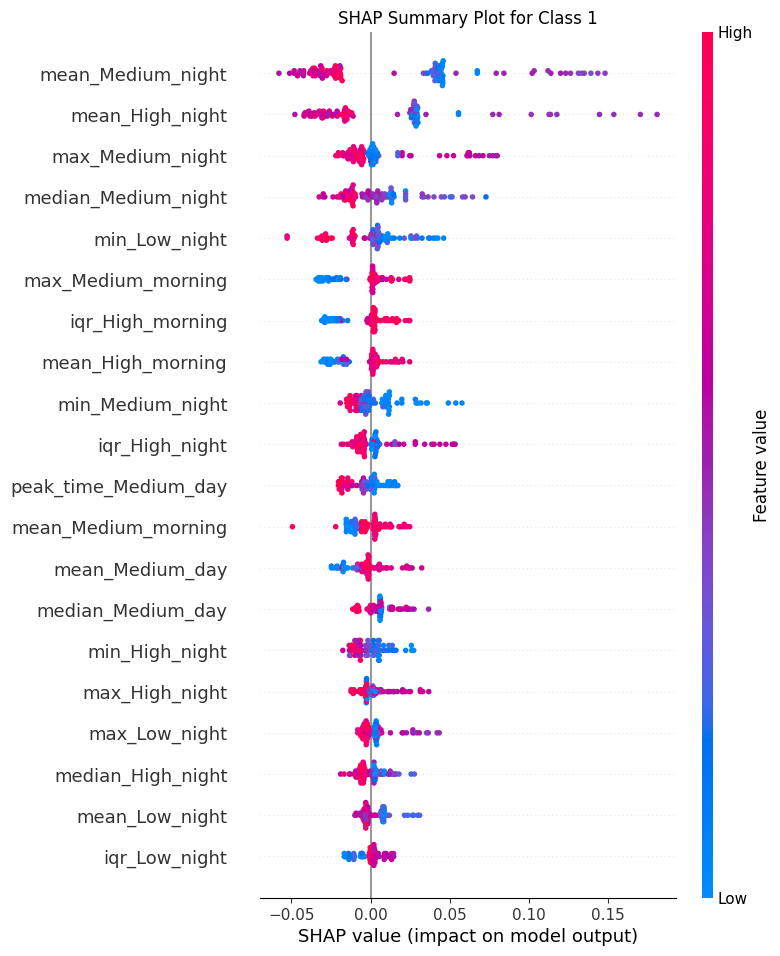

Class 2


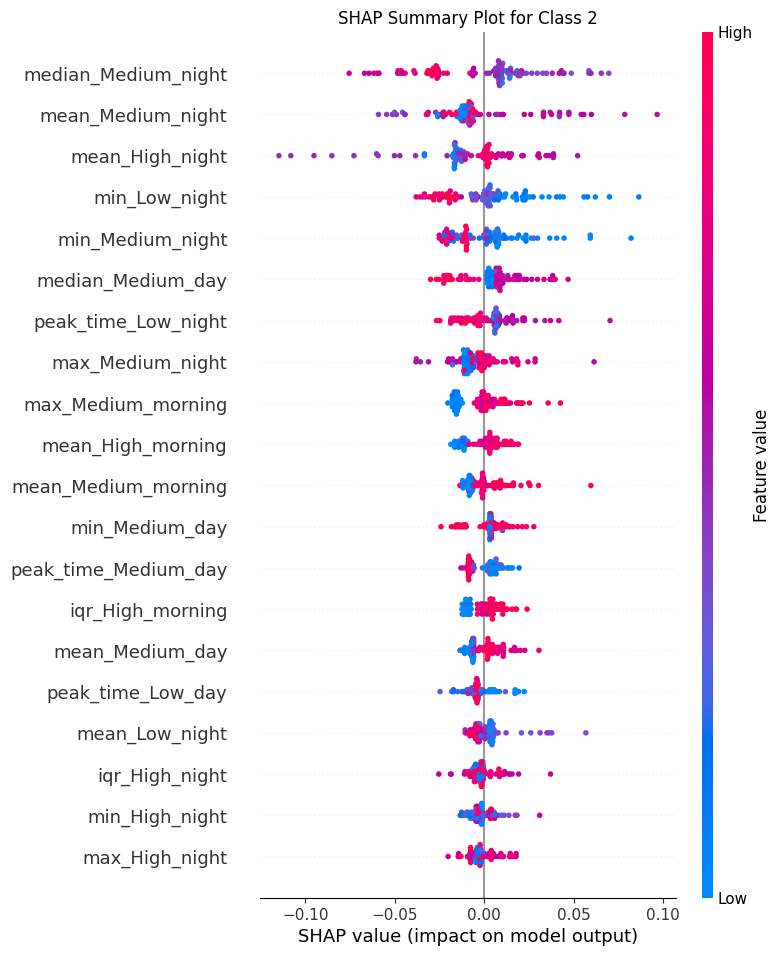

Class 3


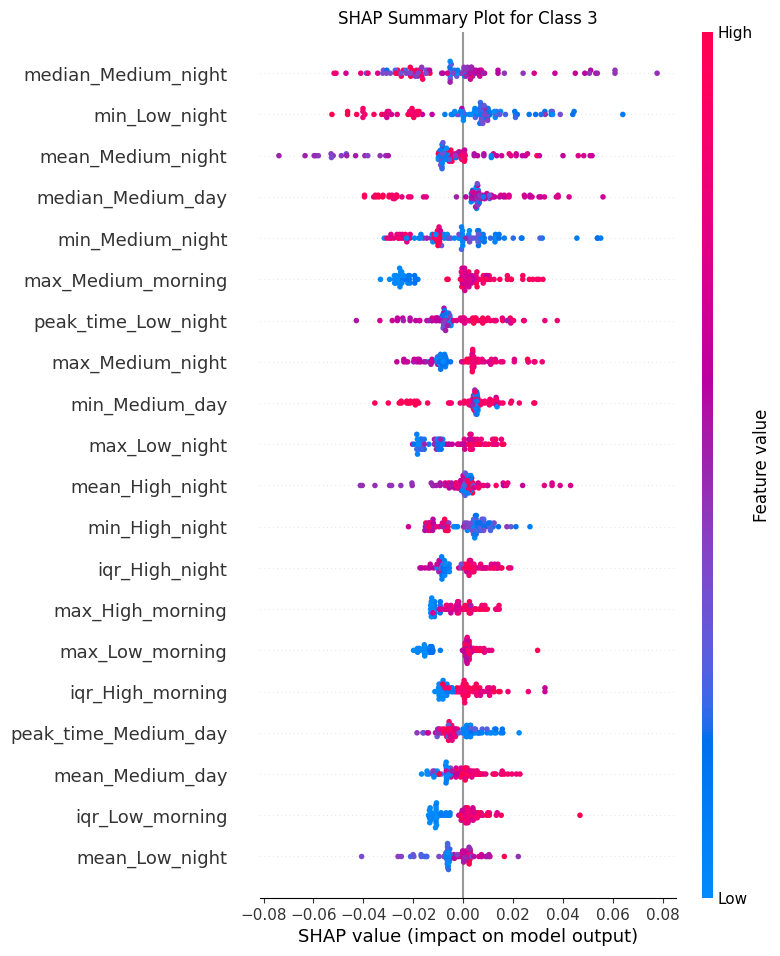

Class 4


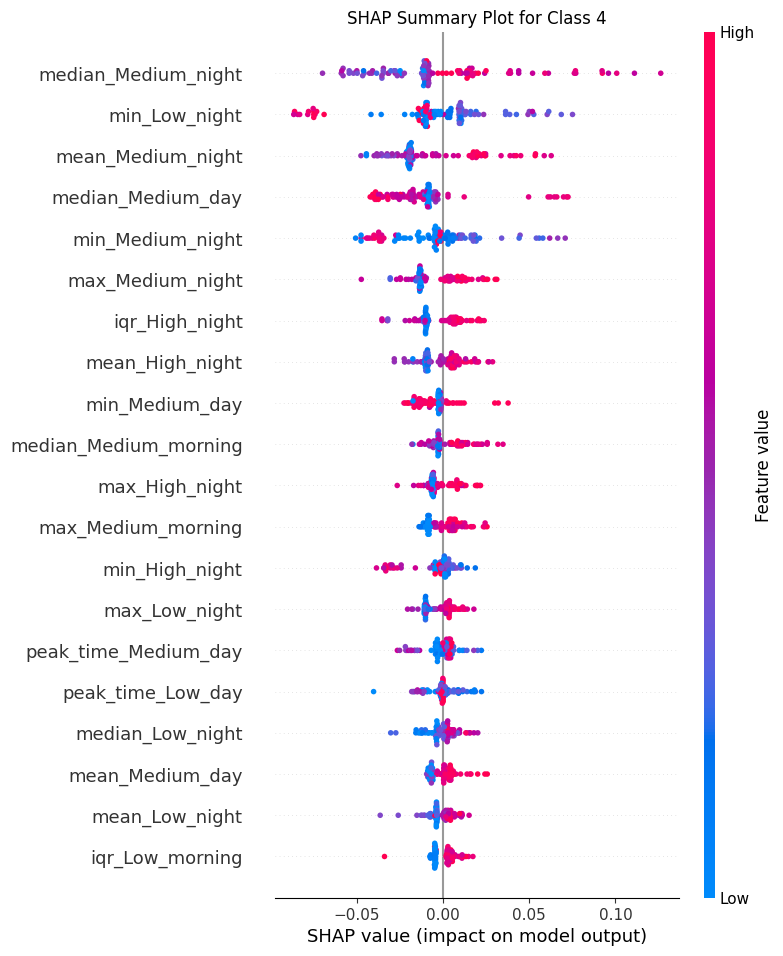

Class 5


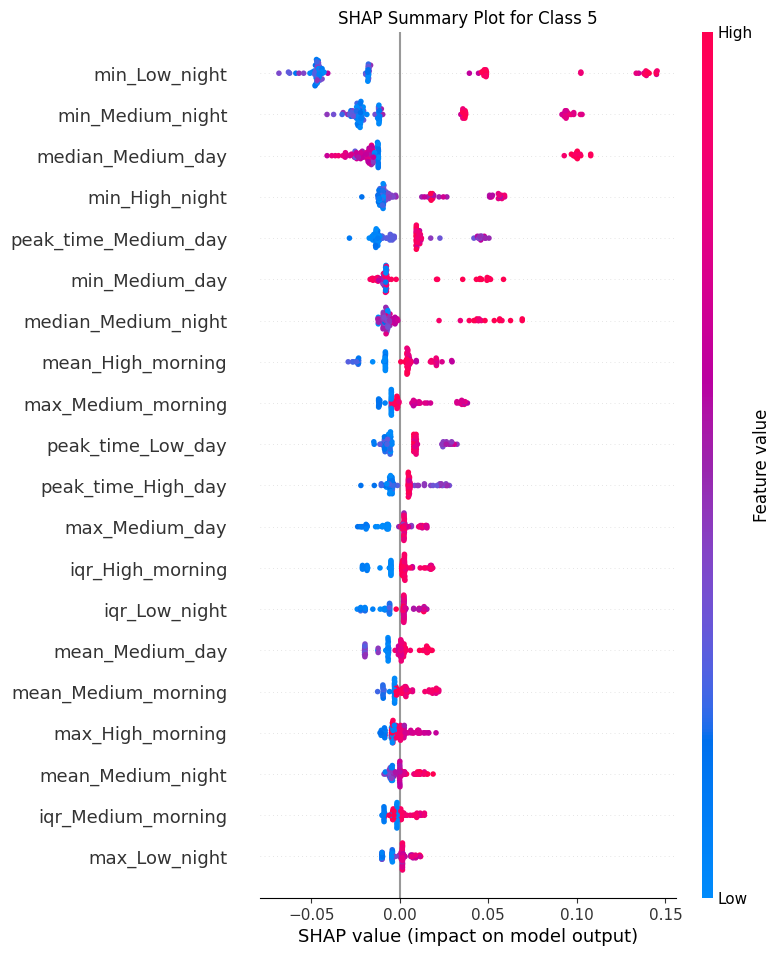

Class 6


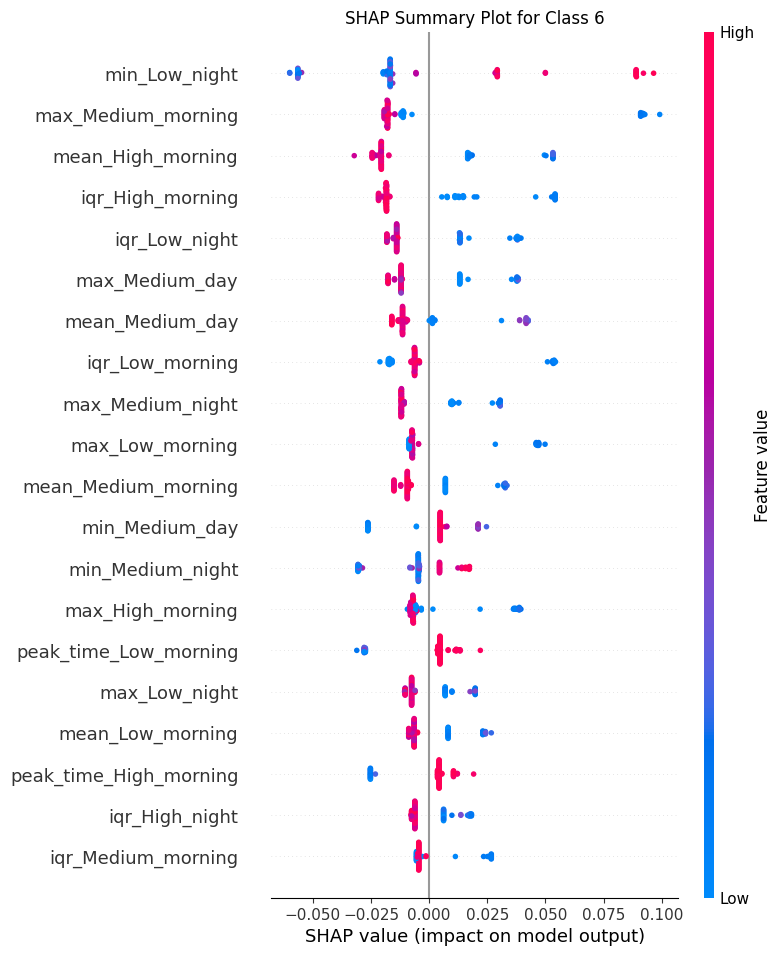

In [ ]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(best_rf_model)

# Select a sample of the test data
num_samples = 100
X_test_sample = X_test_model.iloc[:num_samples]

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Check the shape of shap_values
print("shap_values shape:", shap_values.shape)
print("X_test_sample shape:", X_test_sample.shape)

# Plot summary plot for all classes
num_classes = shap_values.shape[2]
for class_index in range(num_classes):
    print(f"Class {class_index}")
    shap.summary_plot(shap_values[:, :, class_index], X_test_sample, show=False)
    plt.title(f'SHAP Summary Plot for Class {class_index}')
    plt.show()

#### LIME

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


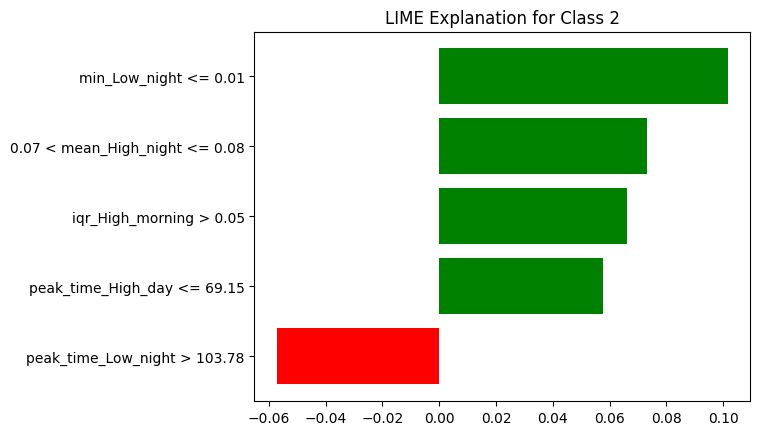

In [ ]:
# Choose an instance to explain
instance_index = 1  # Adjust as needed
instance = X_test_model.iloc[instance_index]

# Get the predicted class for the instance
predicted_class = best_rf_model.predict(instance.to_frame().T)[0]

# Initialize LIME explainer
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=[str(i) for i in np.unique(y_train)],
    mode='classification'
)

# Define prediction function
def predict_proba_fn(data):
    return model.predict_proba(data)

# Explain the instance using LIME
exp = explainer_lime.explain_instance(
    data_row=instance.values,
    predict_fn=predict_proba_fn,
    num_features=5,
    labels=[predicted_class]
)

# Display the explanation
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure(label=predicted_class)
plt.title(f'LIME Explanation for Class {predicted_class}')
plt.show()
